In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [7]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [8]:
data = pd.read_csv('../../Data/20x43_D1060.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,pub_rec,months_cr_line,term,initial_list_status,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.274940,-0.184102,1.311385,-0.819734,-0.819734,-0.643016,-0.284620,-0.307975,-1.102652,-0.320978,-0.916391,-0.442188,-0.056501,-0.161202,-0.046841,-0.782920,1.081878,-1.829511,-0.069254,0.876318,-1.305077,0.970118,-0.028217,-0.952594,-0.369497,1.216261,-0.156365,-0.320362,-0.858014,-0.287554,-0.120532,-0.194898,-0.199254,5.189733,-0.513144,-0.048912,-0.133468,-0.164197,-0.056501,-0.680683,-0.770166,1.488232,0.0
1,-1.703308,-0.172927,-0.550169,-0.538202,-0.538202,-0.643016,-1.704670,-0.833958,-0.301199,-0.284038,-0.916391,-0.442188,-0.056501,-0.161202,-0.107754,-0.846388,-0.354152,-0.248663,-0.069254,0.876318,-1.305077,-0.087275,-0.028217,-0.952594,-0.369497,1.216261,-0.156365,-0.320362,-0.858014,-0.287554,-0.120532,-0.194898,-0.199254,-0.192688,1.948771,-0.048912,-0.133468,-0.164197,-0.056501,1.469112,-0.770166,-0.671938,0.0
2,-0.188373,0.050580,-0.932357,-0.819734,-0.819734,1.336744,-0.155399,-0.132647,-0.221053,-0.503128,-0.045057,-0.442188,-0.056501,-0.161202,-0.107754,-0.843614,3.953939,0.407996,-0.069254,0.876318,0.766238,-1.673364,-0.028217,-0.952594,-0.369497,1.216261,-0.156365,-0.320362,-0.858014,3.477607,-0.120532,-0.194898,-0.199254,-0.192688,-0.513144,-0.048912,-0.133468,-0.164197,-0.056501,-0.680683,1.298421,-0.671938,1.0
3,0.255287,-0.161752,-0.160924,0.587924,0.587924,1.336744,0.294572,-0.132647,-0.942361,-0.561085,-0.916391,-0.442188,-0.056501,-0.161202,-0.107754,-0.695133,-0.354152,-0.418909,-0.069254,0.876318,0.766238,-0.880319,-0.028217,-0.952594,-0.369497,1.216261,-0.156365,-0.320362,-0.858014,-0.287554,-0.120532,-0.194898,-0.199254,-0.192688,-0.513144,-0.048912,-0.133468,6.090231,-0.056501,1.469112,-0.770166,-0.671938,1.0
4,0.460885,-0.200865,0.964475,0.587924,0.587924,1.336744,0.503030,-0.132647,-0.461489,0.018166,-0.916391,-0.442188,-0.056501,-0.161202,-0.107754,0.480341,-0.354152,-0.637795,-0.069254,0.876318,0.766238,-1.409016,-0.028217,1.049765,-0.369497,-0.822192,6.395311,-0.320362,-0.858014,-0.287554,-0.120532,-0.194898,-0.199254,-0.192688,-0.513144,-0.048912,-0.133468,-0.164197,-0.056501,-0.680683,-0.770166,1.488232,0.0


In [9]:
data.shape

(1257, 43)

In [10]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    1032
0.0     225
Name: loan_status_bin, dtype: int64

In [11]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(1257, 42)

In [12]:
y = data['loan_status_bin']

In [13]:
lr1 = LogisticRegression()

In [14]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [15]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.81349206 0.82142857 0.80079681 0.812749   0.82071713]
0.8138367166255612


In [16]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[   4,  221],
       [  13, 1019]])

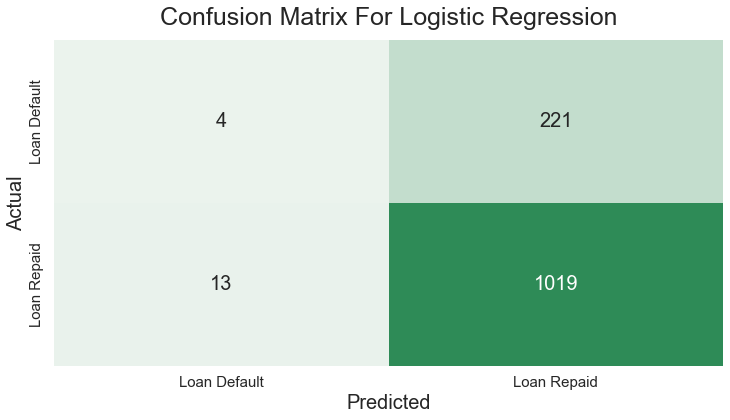

In [17]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [18]:
accuracy_score(y, y_pred)

0.8138424821002387

In [19]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

1019
221
13
4
0.8138424821002387


In [20]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    1032
0.0     225
Name: loan_status_bin, dtype: int64

0.8210023866348448


In [21]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8217741935483871

In [22]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [23]:
y_pred_prob

array([[0.11577251, 0.88422749],
       [0.08288712, 0.91711288],
       [0.12877616, 0.87122384],
       ...,
       [0.28379891, 0.71620109],
       [0.17700244, 0.82299756],
       [0.15258322, 0.84741678]])

In [24]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([1., 1., 1., ..., 0., 1., 1.])

In [25]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 97, 128],
       [349, 683]])

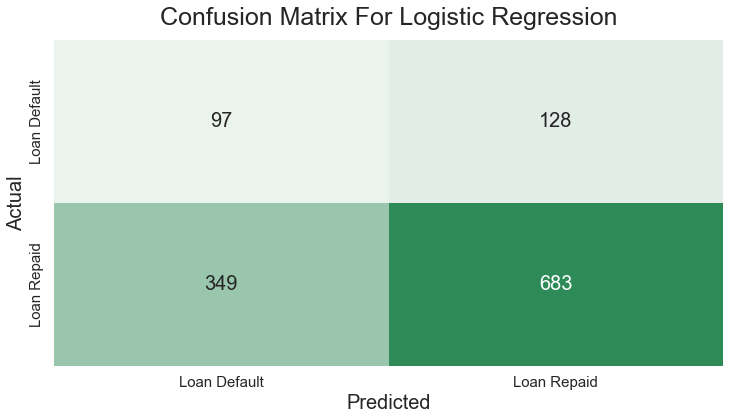

In [26]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [27]:
accuracy_score(y, y_pred_success)

0.6205250596658711

In [28]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

683
128
349
97
0.6205250596658711


In [29]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.842170160295931

In [ ]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [ ]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 